In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers
import tensorflow as tf
import sklearn

In [2]:
# 输出当前使用的库版本
print("NumPy 版本:", np.__version__)
print("Pandas 版本:", pd.__version__)
# print("Matplotlib 版本:", plt.__version__)
print("Seaborn 版本:", sns.__version__)
print("Scikit-learn 版本:", sklearn.__version__)
print("TensorFlow 版本:", tf.__version__)
# print("Keras 版本:", keras.__version__)

NumPy 版本: 1.24.3
Pandas 版本: 2.0.3
Seaborn 版本: 0.12.2
Scikit-learn 版本: 1.3.0
TensorFlow 版本: 2.13.0


In [2]:
def del_no_pump_index(df):
    """
    Deletes the rows where the pump is not running
    """
    # df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    # 将第一个列设为索引
    orginal = df.shape[0]

    # 找出没有被pump的pump_index
    pump_index = df['pump_index'].unique()
    nopump_index = []
    nopump_symbol = []
    for i in pump_index:
        df_pump = df[df['pump_index'] == i]
        # 如果df_pump的列gt不存在等于1, 打印i
        if 1 not in df_pump['gt'].values:
            nopump_symbol.append(df_pump['symbol'].unique().tolist()[0])
            nopump_index.append(i)
    print('nopump_index: ', nopump_index)
    print('nopump_symbol: ', nopump_symbol)

    print('df.shape: ', df.shape)
    print(df['pump_index'].unique().shape)

    # 删除pump_index的值等于48的行
    for i in nopump_index:
        df = df.drop(df[df['pump_index'] == i].index)

    print('df_cleaned.shape: ', df.shape)
    print(df['pump_index'].unique().shape)
    now = df.shape[0]
    print('deleted: ', orginal - now)
    return df

In [3]:
def split_dataset(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    df = del_no_pump_index(df)

    # set random seed
    np.random.seed(2021)

    # train_num为训练集的数量, test_num为测试集的数量
    train_num=np.round(317*0.8) # 254
    test_num=317-train_num      # 63

    # 查看pump_index的值
    index = df['pump_index'].unique()

    # 选取index中的train_num个数作为训练集
    train_index = np.random.choice(index, int(train_num), replace=False)
    # 选取剩下的作为测试集
    test_index = np.setdiff1d(index, train_index)

    # 选取训练集, 选取测试集
    train = df[df['pump_index'].isin(train_index)]
    test = df[df['pump_index'].isin(test_index)]
    print(train.shape, test.shape)

    # 选取训练集的特征
    X_train = train.drop(['gt'], axis=1)
    y_train = train['gt']
    X_test = test.drop(['gt'], axis=1)
    y_test = test['gt']
    return X_train, y_train, X_test, y_test

In [12]:
# --------------------------------------------------------------------------------------------------
def lstm_autoencoder(time_freq, X_train, y_train, X_test, y_test):
    X_train.drop(['date','pump_index','symbol'], axis=1, inplace=True)
    X_test.drop(['date','pump_index','symbol'], axis=1, inplace=True)

    # normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train normal data
    X_train_normal = X_train[y_train == 0]
    y_train_normal = y_train[y_train == 0]
    X_train = X_train_normal
    y_train = y_train_normal

    # train abnormal data
    X_train_abnormal = X_train[y_train == 1]
    y_train_abnormal = y_train[y_train == 1]

    # # concatenate normal data and abnormal data 
    # X_test = np.concatenate((X_train_abnormal, X_test), axis=0)
    # y_test = np.concatenate((y_train_abnormal, y_test), axis=0)

    # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # 构建LSTM自编码器模型
    reg = 0.0001
    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    encoded = LSTM(32, activation='relu', return_sequences=True
                    , kernel_regularizer=regularizers.l2(reg)
                    )(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(X_train.shape[1])(encoded)
    decoded = LSTM(16, activation='relu', return_sequences=True,)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(X_train.shape[2]))(decoded)
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mae')
    # adam = optimizers.Adam(learning_rate=0.0001)
    # autoencoder.compile(optimizer=adam, loss='mae')
    # autoencoder.summary()
    
    # 使用训练数据训练LSTM自编码器模型
    early_stopping = EarlyStopping(monitor='val_loss'
                                # , min_delta=0.0001
                                , patience=12
                                , verbose=1
                                # , mode='min'
                                , restore_best_weights=True)
    history= autoencoder.fit(X_train, X_train
                            , epochs=150
                            , batch_size=32
                            , validation_split=0.1
                            , callbacks=[early_stopping]
                            )

    # plot loss curve
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('LSTM-AutoEncoder Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # 使用训练好的LSTM自编码器重构训练数据
    X_train_pred = autoencoder.predict(X_train)
    X_train_pred = X_train_pred.reshape(X_train_pred.shape[0], X_train_pred.shape[2])
    trainX = X_train.reshape(X_train.shape[0], X_train.shape[2])

    # 计算还原误差MAE
    train_mae = np.mean(np.abs(trainX - X_train_pred), axis=1)

    # 使用训练好的LSTM自编码器重构测试数据
    X_test_pred = autoencoder.predict(X_test)
    X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
    testX = X_test.reshape(X_test.shape[0], X_test.shape[2])

    # 计算还原误差MAE
    test_mae = np.mean(np.abs(testX - X_test_pred), axis=1)

    return autoencoder, train_mae, y_train, test_mae, y_test



# --------------------------------------------------------------------------------------------------
def pick_threshold(y, preds):
    thresholds = np.linspace(0, 10, 1000)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold
# ------------------------------set threshold--------------------------------------------------------
def set_threshold(y_test, test_mae, threshold):
    # 设置阈值
    threshold = threshold
    print("Reconstruction error threshold: ", threshold)
    y_test_pred = np.where(test_mae >= threshold , 1, 0)

    # precision, recall, f1-score
    print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))
    print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
    print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
    

    # plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# LSTM AutoEncoder

- 25S

In [9]:
X_train, y_train, X_test, y_test = split_dataset('25S')

nopump_index:  [48, 149, 156, 180, 224, 264, 299, 300, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'HC', 'RDN', 'RDN', 'WINGS']
df.shape:  (482157, 16)
(327,)
df_cleaned.shape:  (482137, 16)
(317,)
deleted:  20
(384398, 16) (97739, 16)


Epoch 1/150
10805/10805 [==============================] - 27s 2ms/step - loss: 0.0891 - val_loss: 0.0621
Epoch 2/150
10805/10805 [==============================] - 24s 2ms/step - loss: 0.0467 - val_loss: 0.0498
Epoch 3/150
10805/10805 [==============================] - 23s 2ms/step - loss: 0.0441 - val_loss: 0.0455
Epoch 4/150
10805/10805 [==============================] - 22s 2ms/step - loss: 0.0371 - val_loss: 0.0314
Epoch 5/150
10805/10805 [==============================] - 22s 2ms/step - loss: 0.0228 - val_loss: 0.0292
Epoch 6/150
10805/10805 [==============================] - 22s 2ms/step - loss: 0.0221 - val_loss: 0.0274
Epoch 7/150
10805/10805 [==============================] - 22s 2ms/step - loss: 0.0216 - val_loss: 0.0287
Epoch 8/150
10805/10805 [==============================] - 23s 2ms/step - loss: 0.0213 - val_loss: 0.0276
Epoch 9/150
10805/10805 [==============================] - 26s 2ms/step - loss: 0.0208 - val_loss: 0.0278
Epoch 10/150
10805/10805 [====================

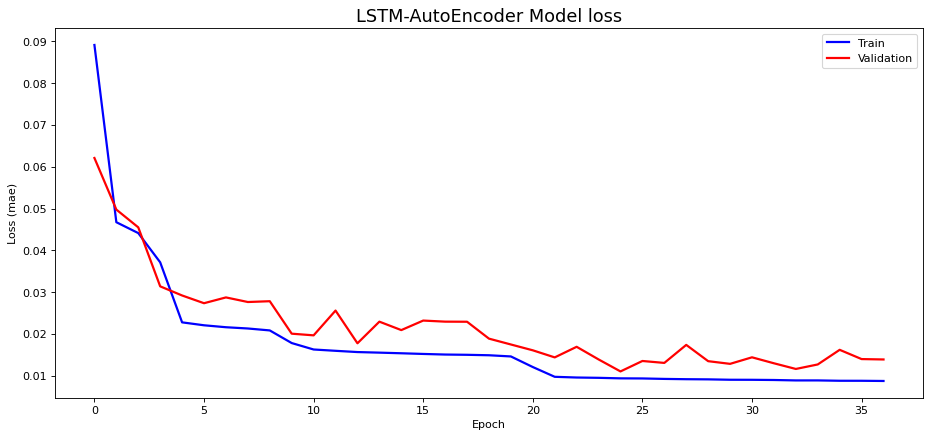

3055/3055 [==============================] - 3s 999us/step


In [10]:
autoencoder_25S, train_mae_25S, y_train_25S, test_mae_25S, y_test_25S = lstm_autoencoder(time_freq='25S', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

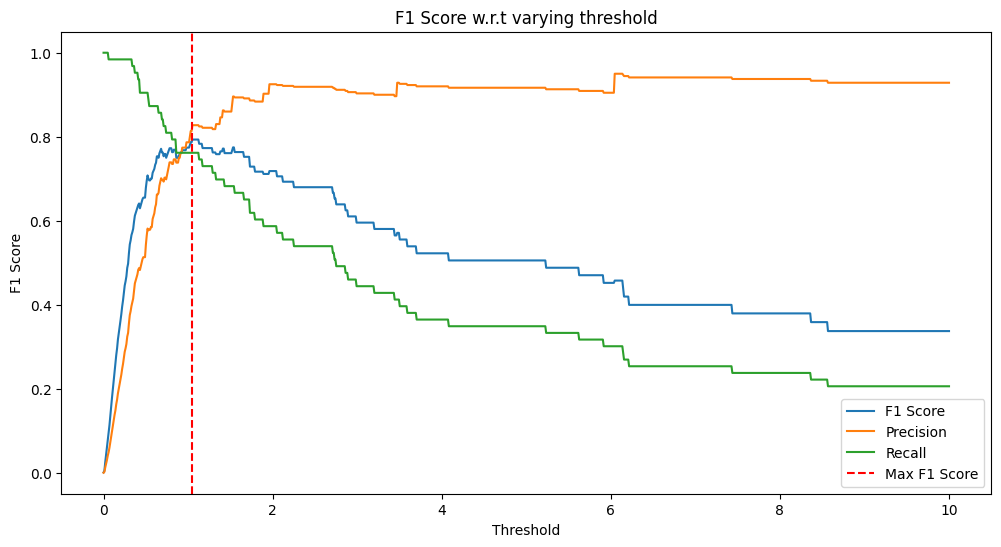

Best threshold:  1.0510510510510511
Best F1 Score:  0.7933884297520662
Recall:  0.7619047619047619
Precision:  0.8275862068965517


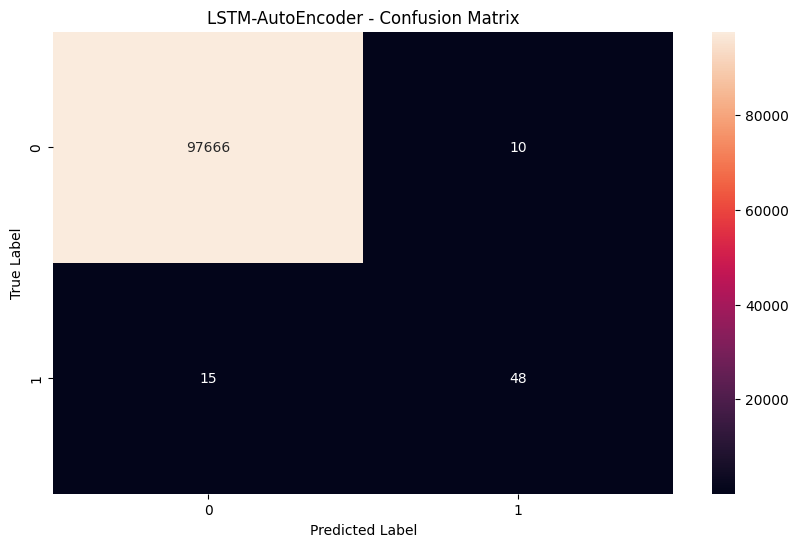

In [14]:
threshold_25S = pick_threshold(y_test_25S, test_mae_25S)

# Best threshold:  1.0510510510510511
# Best F1 Score:  0.7933884297520662
# Recall:  0.7619047619047619
# Precision:  0.8275862068965517

- 15S

In [15]:
X_train, y_train, X_test, y_test = split_dataset('15S')

nopump_index:  [48, 149, 156, 180, 224, 264, 299, 300, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'HC', 'RDN', 'RDN', 'WINGS']
df.shape:  (584104, 16)
(327,)
df_cleaned.shape:  (584081, 16)
(317,)
deleted:  23
(466709, 16) (117372, 16)


Epoch 1/150
13120/13120 [==============================] - 33s 2ms/step - loss: 0.1173 - val_loss: 0.0872
Epoch 2/150
13120/13120 [==============================] - 29s 2ms/step - loss: 0.0725 - val_loss: 0.0456
Epoch 3/150
13120/13120 [==============================] - 26s 2ms/step - loss: 0.0281 - val_loss: 0.0324
Epoch 4/150
13120/13120 [==============================] - 27s 2ms/step - loss: 0.0265 - val_loss: 0.0309
Epoch 5/150
13120/13120 [==============================] - 28s 2ms/step - loss: 0.0258 - val_loss: 0.0293
Epoch 6/150
13120/13120 [==============================] - 27s 2ms/step - loss: 0.0255 - val_loss: 0.0289
Epoch 7/150
13120/13120 [==============================] - 27s 2ms/step - loss: 0.0251 - val_loss: 0.0293
Epoch 8/150
13120/13120 [==============================] - 26s 2ms/step - loss: 0.0247 - val_loss: 0.0280
Epoch 9/150
13120/13120 [==============================] - 28s 2ms/step - loss: 0.0244 - val_loss: 0.0296
Epoch 10/150
13120/13120 [====================

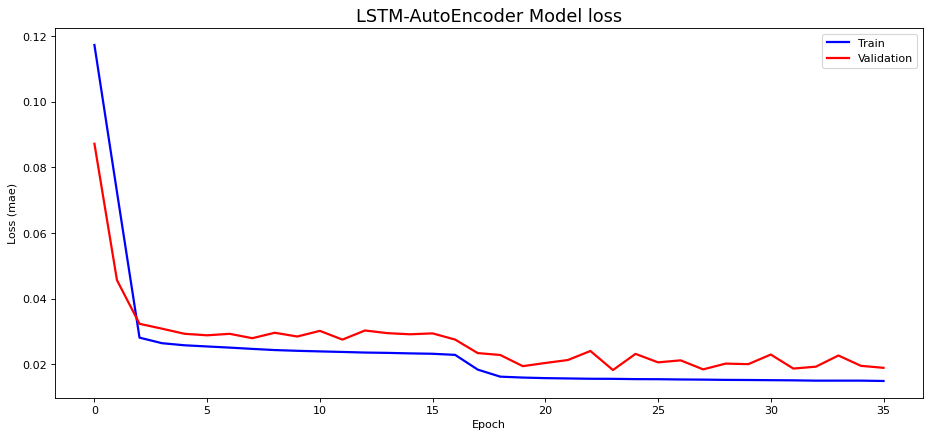

3668/3668 [==============================] - 3s 940us/step


In [16]:
autoencoder_15S, train_mae_15S, y_train_15S, test_mae_15S, y_test_15S = lstm_autoencoder(time_freq='15S', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

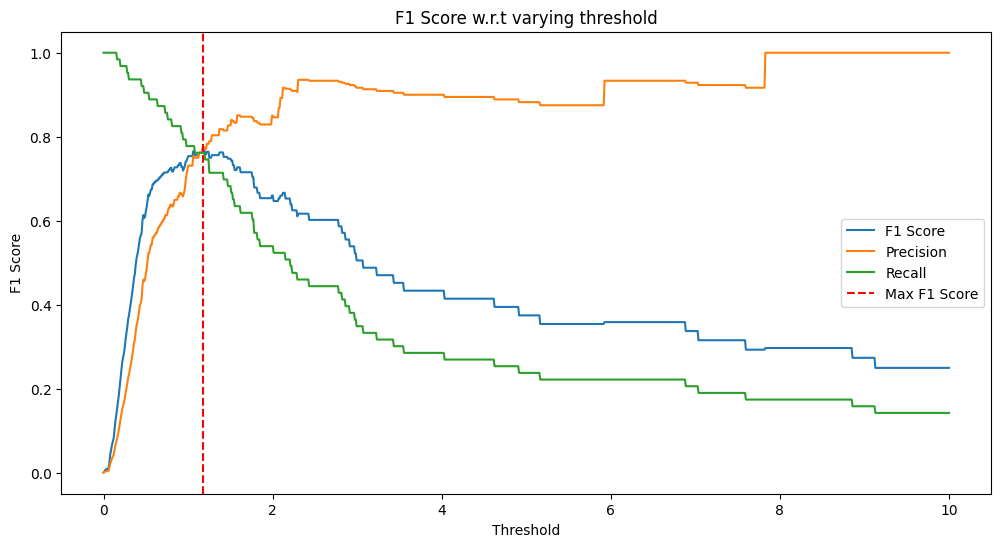

Best threshold:  1.1711711711711712
Best F1 Score:  0.768
Recall:  0.7619047619047619
Precision:  0.7741935483870968


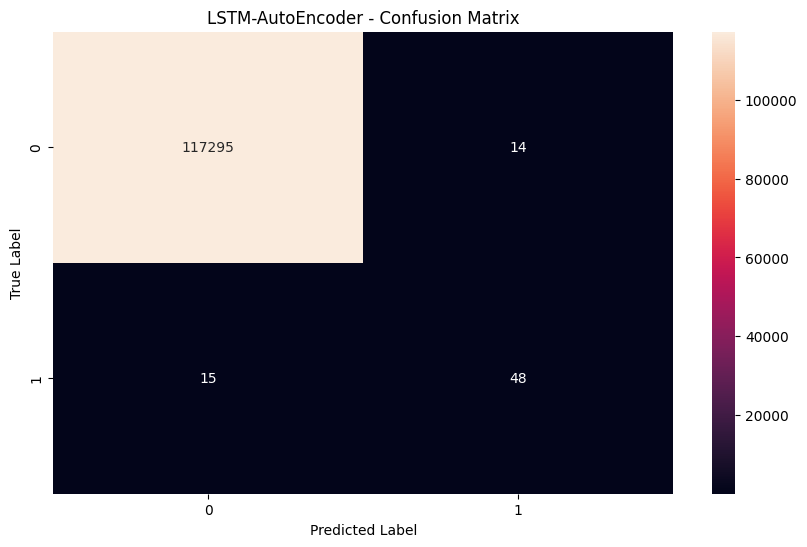

In [17]:
threshold_15S = pick_threshold(y_test_15S, test_mae_15S)

# Best threshold:  1.1711711711711712
# Best F1 Score:  0.768
# Recall:  0.7619047619047619
# Precision:  0.7741935483870968

In [11]:
# threshold = threshold_15S
# set_threshold(y_test_15S, test_mae_15S, threshold)

- 5S

In [18]:
X_train, y_train, X_test, y_test = split_dataset('5S')

nopump_index:  [48, 149, 156, 180, 224, 264, 300, 327, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'RDN', 'GRS', 'RDN', 'WINGS']
df.shape:  (821307, 16)
(327,)
df_cleaned.shape:  (821275, 16)
(317,)
deleted:  32
(657755, 16) (163520, 16)


Epoch 1/150
18493/18493 [==============================] - 47s 2ms/step - loss: 0.1116 - val_loss: 0.0656
Epoch 2/150
18493/18493 [==============================] - 39s 2ms/step - loss: 0.0426 - val_loss: 0.0408
Epoch 3/150
18493/18493 [==============================] - 40s 2ms/step - loss: 0.0359 - val_loss: 0.0386
Epoch 4/150
18493/18493 [==============================] - 43s 2ms/step - loss: 0.0312 - val_loss: 0.0250
Epoch 5/150
18493/18493 [==============================] - 42s 2ms/step - loss: 0.0236 - val_loss: 0.0225
Epoch 6/150
18493/18493 [==============================] - 43s 2ms/step - loss: 0.0226 - val_loss: 0.0257
Epoch 7/150
18493/18493 [==============================] - 40s 2ms/step - loss: 0.0221 - val_loss: 0.0241
Epoch 8/150
18493/18493 [==============================] - 40s 2ms/step - loss: 0.0216 - val_loss: 0.0232
Epoch 9/150
18493/18493 [==============================] - 41s 2ms/step - loss: 0.0212 - val_loss: 0.0244
Epoch 10/150
18493/18493 [====================

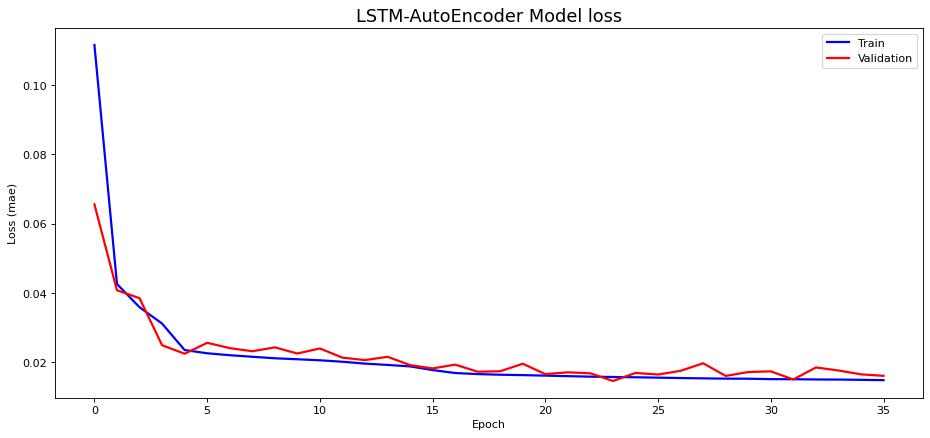

5110/5110 [==============================] - 5s 912us/step


In [19]:
autoencoder_5S, train_mae_5S, y_train_5S, test_mae_5S, y_test_5S = lstm_autoencoder(time_freq='5S', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

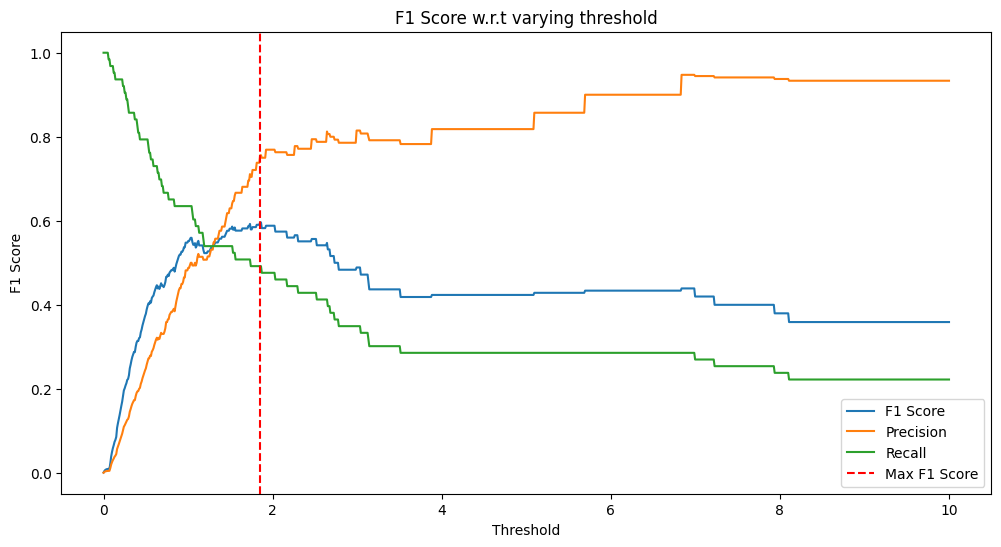

Best threshold:  1.8518518518518519
Best F1 Score:  0.5961538461538461
Recall:  0.49206349206349204
Precision:  0.7560975609756098


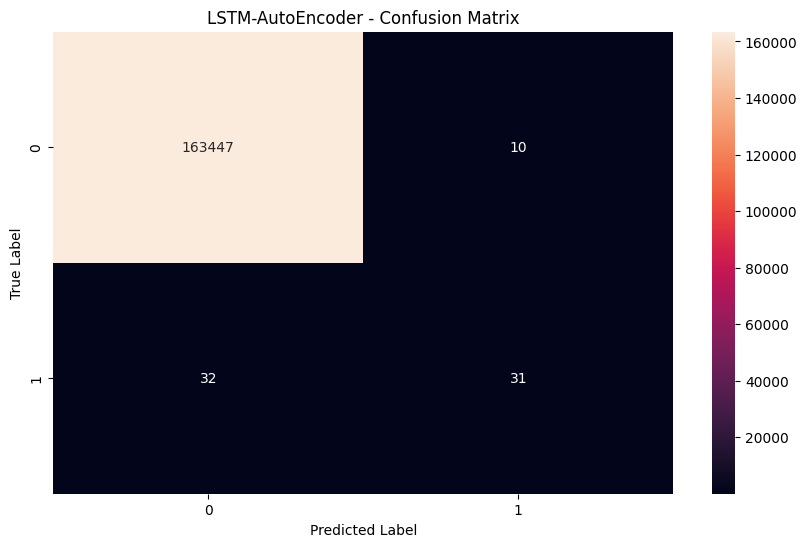

In [20]:
threshold_5S = pick_threshold(y_test_5S, test_mae_5S)

# Best threshold:  1.1311311311311312
# Best F1 Score:  0.5666666666666667
# Recall:  0.5396825396825397
# Precision:  0.5964912280701754

Best threshold:  0.32432432432432434
Best F1 Score:  0.7386172006745363
Recall:  0.6908517350157729
Precision:  0.7934782608695652

Reconstruction error threshold_5S:  1.8518518518518519
Reconstruction error threshold_15S:  1.1711711711711712
Reconstruction error threshold_25S:  1.0510510510510511
5S: F1 Score: 0.5961538461538461, Recall: 0.49206349206349204, Precision: 0.7560975609756098
15S: F1 Score: 0.768, Recall: 0.7619047619047619, Precision: 0.7741935483870968
25S: F1 Score: 0.7933884297520662, Recall: 0.7619047619047619, Precision: 0.8275862068965517


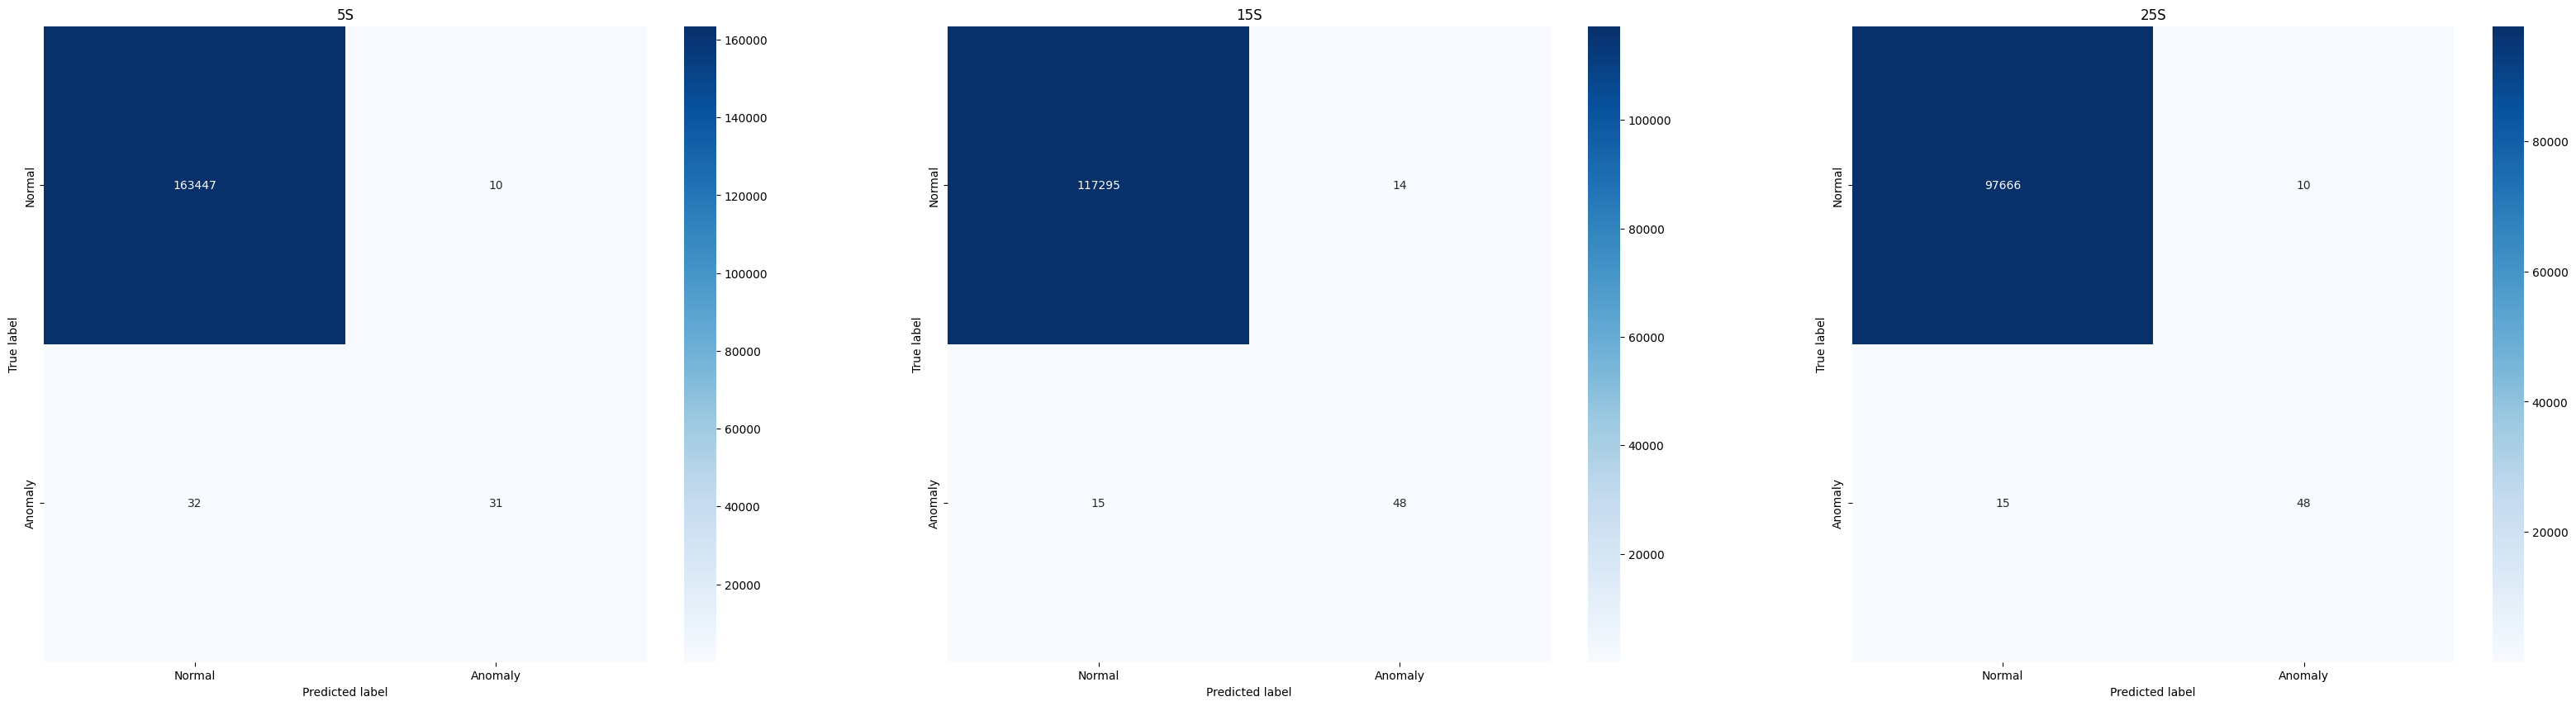

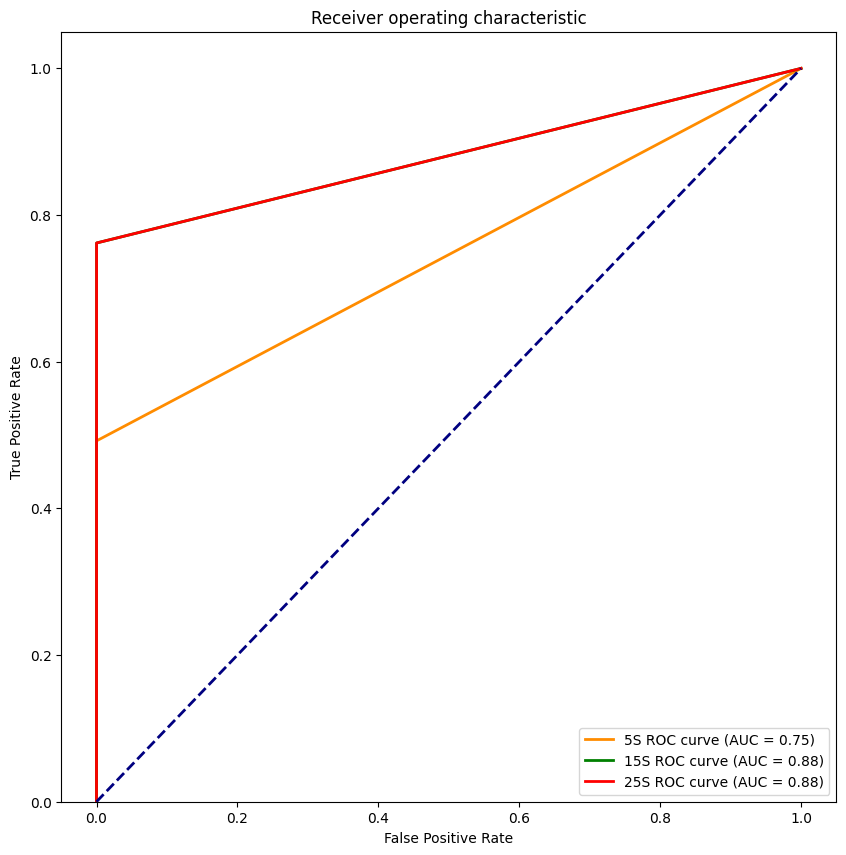

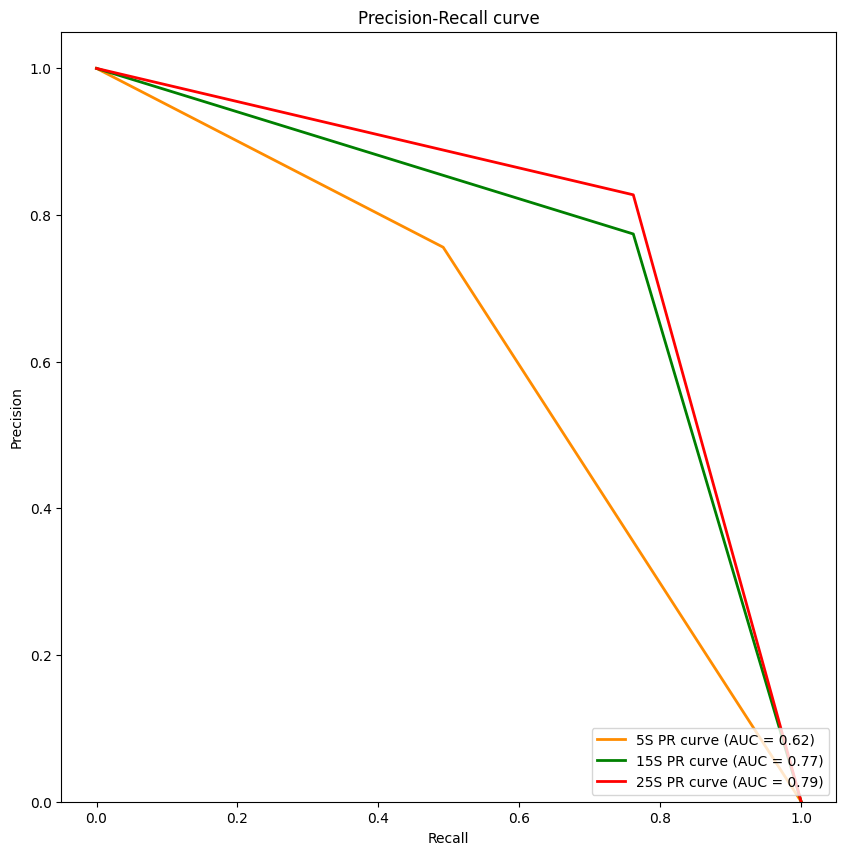

In [26]:
# 设置阈值
print("Reconstruction error threshold_5S: ", threshold_5S)
print("Reconstruction error threshold_15S: ", threshold_15S)
print("Reconstruction error threshold_25S: ", threshold_25S)

y_test_pred_5S = np.where(test_mae_5S >= threshold_5S , 1, 0)
y_test_pred_15S = np.where(test_mae_15S >= threshold_15S , 1, 0)
y_test_pred_25S = np.where(test_mae_25S >= threshold_25S , 1, 0)

# Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_test_prod_5S = sigmoid(y_test_pred_5S)
y_test_prod_15S = sigmoid(y_test_pred_15S)
y_test_prod_25S = sigmoid(y_test_pred_25S)

# precision, recall, f1-score
from sklearn.metrics import f1_score, recall_score, precision_score
F1_score_5S = f1_score(y_test_5S, y_test_pred_5S)
Recall_5S = recall_score(y_test_5S, y_test_pred_5S)
Precision_5S = precision_score(y_test_5S, y_test_pred_5S)

F1_score_15S = f1_score(y_test_15S, y_test_pred_15S)
Recall_15S = recall_score(y_test_15S, y_test_pred_15S)
Precision_15S = precision_score(y_test_15S, y_test_pred_15S)

F1_score_25S = f1_score(y_test_25S, y_test_pred_25S)
Recall_25S = recall_score(y_test_25S, y_test_pred_25S)
Precision_25S = precision_score(y_test_25S, y_test_pred_25S)

print('5S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_5S, Recall_5S, Precision_5S))
print('15S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_15S, Recall_15S, Precision_15S))
print('25S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_25S, Recall_25S, Precision_25S))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_5S = confusion_matrix(y_test_5S, y_test_pred_5S)
confusion_matrix_15S = confusion_matrix(y_test_15S, y_test_pred_15S)
confusion_matrix_25S = confusion_matrix(y_test_25S, y_test_pred_25S)

plt.figure(figsize=(40,10))
plt.subplot(1,3,1)
plt.title('5S')
sns.heatmap(confusion_matrix_5S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,2)
plt.title('15S')
sns.heatmap(confusion_matrix_15S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,3)
plt.title('25S')
sns.heatmap(confusion_matrix_25S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')


# plot ROC curve
from sklearn.metrics import roc_curve, auc
# fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_pred_5S)
fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_prod_5S)
roc_auc_5S = auc(fpr_5S, tpr_5S)


# fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_pred_15S)
fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_prod_15S)
roc_auc_15S = auc(fpr_15S, tpr_15S)

# fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_pred_25S)
fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_prod_25S)
roc_auc_25S = auc(fpr_25S, tpr_25S)

plt.figure(figsize=(10,10))
plt.plot(fpr_5S, tpr_5S, color='darkorange', lw=2, label='5S ROC curve (AUC = %0.2f)' % roc_auc_5S) # lw: line width
plt.plot(fpr_15S, tpr_15S, color='green', lw=2, label='15S ROC curve (AUC = %0.2f)' % roc_auc_15S) # lw: line width
plt.plot(fpr_25S, tpr_25S, color='red', lw=2, label='25S ROC curve (AUC = %0.2f)' % roc_auc_25S) # lw: line width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 画对角线
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('False Positive Rate') # x轴标签
plt.ylabel('True Positive Rate') # y轴标签
plt.title('Receiver operating characteristic') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()


# plot PR curve
from sklearn.metrics import precision_recall_curve
# precision_5S, recall_5S, thresholds_5S = precision_recall_curve(y_test_5S, y_test_pred_5S)
# precision_15S, recall_15S, thresholds_15S = precision_recall_curve(y_test_15S, y_test_pred_15S)
# precision_25S, recall_25S, thresholds_25S = precision_recall_curve(y_test_25S, y_test_pred_25S)

precision_5S, recall_5S, thresholds_5S = precision_recall_curve(y_test_5S, y_test_prod_5S)
precision_15S, recall_15S, thresholds_15S = precision_recall_curve(y_test_15S, y_test_prod_15S)
precision_25S, recall_25S, thresholds_25S = precision_recall_curve(y_test_25S, y_test_prod_25S)

plt.figure(figsize=(10,10))
plt.plot(recall_5S, precision_5S, color='darkorange', lw=2, label='5S PR curve (AUC = %0.2f)' % auc(recall_5S, precision_5S)) # lw: line width
plt.plot(recall_15S, precision_15S, color='green', lw=2, label='15S PR curve (AUC = %0.2f)' % auc(recall_15S, precision_15S)) # lw: line width
plt.plot(recall_25S, precision_25S, color='red', lw=2, label='25S PR curve (AUC = %0.2f)' % auc(recall_25S, precision_25S)) # lw: line width
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('Recall') # x轴标签
plt.ylabel('Precision') # y轴标签
plt.title('Precision-Recall curve') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()

不包含Train的异常值
Reconstruction error threshold_5S:  1.1311311311311312
Reconstruction error threshold_15S:  1.8418418418418419
Reconstruction error threshold_25S:  0.5505505505505506
5S: F1 Score: 0.5666666666666667, Recall: 0.5396825396825397, Precision: 0.5964912280701754
15S: F1 Score: 0.765217391304348, Recall: 0.6984126984126984, Precision: 0.8461538461538461
25S: F1 Score: 0.7938931297709922, Recall: 0.8253968253968254, Precision: 0.7647058823529411

In [ ]:
# threshold = threshold_5S
# set_threshold(y_test_5S, test_mae_5S, threshold_5S)

In [45]:
# # 设置阈值
# threshold_1 = np.mean(test_mae_loss) + 3 * np.std(test_mae_loss)
# threshold_2 = np.mean(test_mae_loss) - 3 * np.std(test_mae_loss)
# print("Reconstruction error threshold: ", threshold_1, threshold_2)
# y_test_pred = np.where((test_mae_loss >= threshold_1) | (test_mae_loss< threshold_2) , 1, 0)

# # precision, recall, f1-score
# print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
# print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
# print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))

# # plot confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('LSTM-AutoEncoder - Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()